In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [47]:
import glob
import warnings
import numpy as np
import pylab as plt

from scipy.ndimage import binary_dilation

from astropy.io import fits
from astropy.time import Time
from natsort import natsorted
from astropy.stats import sigma_clip
from astropy.convolution import Gaussian2DKernel, convolve

# Make sure we can find lassi-analysis
import sys
sys.path.append('/home/scratch/psalas/LASSI/lassi-analysis_v2')

from rotate import shiftRotateXYZ, primeX, primeY, primeZ
from parabolas import loadLeicaData, fitParabola, parabola, fitLeicaData
from grid import regridXYZ, regridXYZMasked
from plotting import surfacePlot, barChartPlot, scatterPlot
from utils.utils import midPoint, radialMask, gridLimits, stride, rolling_stat, getRollingStat
from zernikies import zernikeWLS, getZernikeCoeffs, zernikePoly
from analyzeActiveSurface import processActiveSurfaceFITSPair
from analysis.March2020.zernike import make_aperture_efficiency, aperture_efficiency_residuals

In [3]:
def parabolaFitIterations(x, y, z, guess=[60., 0, 0, -50., 0, 0], bounds=None, iters=2, 
                          max_nfev=10000, ftol=1e-12, xtol=1e-15, f_scale=1e-4):
    
    mask = np.isnan(z)
    
    for i in range(iters):
        
        x_ = np.ma.masked_where(mask, x)
        y_ = np.ma.masked_where(mask, y)
        z_ = np.ma.masked_where(mask, z)
        
        fit = fitLeicaData(x_.compressed(), y_.compressed(), z_.compressed(), 
                           guess, bounds=bounds, f_scale=f_scale, ftol=ftol, 
                           xtol=xtol, max_nfev=max_nfev)
        
        xdr, ydr, zdr = alignXYZ(x, y, z, fit.x)
        
        zp = parabola(xdr, ydr, fit.x[0])
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            res = sigma_clip(zdr - zp)
        mask = binary_dilation(res.mask, iterations=2)
        guess = fit.x
    
    return fit, mask


def prepareData(filename, n=512, rot=178.):
    orgData, cleanData = loadLeicaData(filename, n=None, numpy=False)
    x = orgData[0]
    y = orgData[1]
    z = orgData[2]
    
    xr, yr, zr = shiftRotateXYZ(x, y, z, [0, 0, 0, 0, 0, np.deg2rad(rot)])
    xg, yg, zg = regridXYZ(xr, yr, zr, n=n)
    
    return xg, yg, zg


def alignXYZ(x, y, z, fit):
    cor = np.hstack((-1*fit[1:4],fit[4:6],0))
    xr, yr, zr = shiftRotateXYZ(x, y, z, cor)
    return xr, yr, zr

In [206]:
n = 512
iters = 1
nZern = 36
guess = [60., 2.5, -0.7, -49., 0.2, 0.]
kernel = Gaussian2DKernel(x_stddev=17.75)
iz = 7
izv = -534
zcoef = np.zeros(nZern)
zcoef[iz] = izv
scanDir = '/home/scratch/psalas/LASSI/gpus/output/'

In [5]:
%%time
#refScan = "{0}/ref_average.ptx.csv".format(scanDir)
refScan = "{0}/2020_03_16_ref_average.ptx.csv".format(scanDir)
xr, yr, zr = prepareData(refScan, n=n, rot=178.)

CPU times: user 1min 2s, sys: 3.06 s, total: 1min 5s
Wall time: 1min


In [247]:
%%time
#sigScan = "{0}/2020_03_16_02:28:31.ptx.csv".format(scanDir) # C4=-518
#sigScan = "{0}/2020_03_16_03:02:51.ptx.csv".format(scanDir) # C4=-486
#sigScan = "{0}/2020_03_16_03:27:25.ptx.csv".format(scanDir) # C4=-167
#sigScan = "{0}/2020_03_16_06:43:17.ptx.csv".format(scanDir) # C4=-562
sigScan = "{0}/2020_03_16_05:30:05.ptx.csv".format(scanDir) # C13=-534
#sigScan = "{0}/2020_03_16_05:54:35.ptx.csv".format(scanDir) # C13=-169
#sigScan = "{0}/2020_03_16_06:18:53.ptx.csv".format(scanDir) # C13=-56
#sigScan = "{0}/2020_03_16_09:09:14.ptx.csv".format(scanDir) # C13=-534
#sigScan = "{0}/2020_03_16_04:16:39.ptx.csv".format(scanDir) # C7=-545
#sigScan = "{0}/2020_03_16_04:41:09.ptx.csv".format(scanDir) # C7=-144
#sigScan = "{0}/2020_03_16_07:56:13.ptx.csv".format(scanDir) # C7=-554
xs, ys, zs = prepareData(sigScan, n=n, rot=178.)

CPU times: user 5.67 s, sys: 2.2 s, total: 7.88 s
Wall time: 3.57 s


In [248]:
xrg, yrg, zrg = xr, yr, zr
xsg, ysg, zsg = xs, ys, zs

In [249]:
%%time
zrgs = convolve(zrg, kernel, boundary='extend', fill_value=0.0, nan_treatment='interpolate', 
                normalize_kernel=True, mask=None, preserve_nan=True, normalization_zero_tol=1e-08)

CPU times: user 5.98 s, sys: 0 ns, total: 5.98 s
Wall time: 5.97 s


In [250]:
zrsFit, zrsMask = parabolaFitIterations(xrg, yrg, zrgs,
                                        guess=guess, bounds=None, iters=10, 
                                        max_nfev=10000, ftol=1e-12, xtol=1e-15, f_scale=1e-5)

In [251]:
zsgs = convolve(zsg, kernel, boundary='extend', fill_value=0.0, nan_treatment='interpolate', 
                normalize_kernel=True, mask=None, preserve_nan=True, normalization_zero_tol=1e-08)

In [252]:
%%time
zssFit, zssMask = parabolaFitIterations(xsg, ysg, zsgs,
                                        guess=guess, bounds=None, iters=10, 
                                        max_nfev=10000, ftol=1e-12, xtol=1e-15, f_scale=1e-5)

CPU times: user 4min 51s, sys: 4min 5s, total: 8min 56s
Wall time: 23.5 s


In [253]:
print(zrsFit.x)
print(zssFit.x)

[ 6.00601972e+01  2.44724283e+00 -9.91700728e-01 -4.91923672e+01
  2.19793555e-01 -5.12147286e-03]
[ 6.00530673e+01  2.45071514e+00 -9.87548911e-01 -4.91907444e+01
  2.19802417e-01 -5.07456681e-03]


In [254]:
pFitR = np.copy(zrsFit.x)
pFitS = np.copy(zssFit.x)
#pFitR[3] = pFitS[3] = 0
#pFitR[1] = pFitR[2] = pFitR[3] = 0
#pFitS[1] = pFitS[2] = pFitS[3] = 0
#pFitR[4] = pFitR[5] = 0
#pFitS[4] = pFitS[5] = 0
#pFitR[5] = pFitS[5] = 0
print(pFitR)
print(pFitS)

[ 6.00601972e+01  2.44724283e+00 -9.91700728e-01 -4.91923672e+01
  2.19793555e-01 -5.12147286e-03]
[ 6.00530673e+01  2.45071514e+00 -9.87548911e-01 -4.91907444e+01
  2.19802417e-01 -5.07456681e-03]


In [255]:
%%time
xra, yra, zra = alignXYZ(xrg, yrg, zrg, pFitR)
xsa, ysa, zsa = alignXYZ(xsg, ysg, zsg, pFitS)

CPU times: user 375 ms, sys: 297 ms, total: 672 ms
Wall time: 38.3 ms


In [256]:
%%time
xmin, xmax = gridLimits(xsa, xra)
ymin, ymax = gridLimits(ysa, yra)
xrag, yrag, zrag = regridXYZ(xra, yra, zra, n=n, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
xsag, ysag, zsag = regridXYZ(xsa, ysa, zsa, n=n, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)

CPU times: user 17.9 s, sys: 3.3 s, total: 21.2 s
Wall time: 14.6 s


<IPython.core.display.Javascript object>


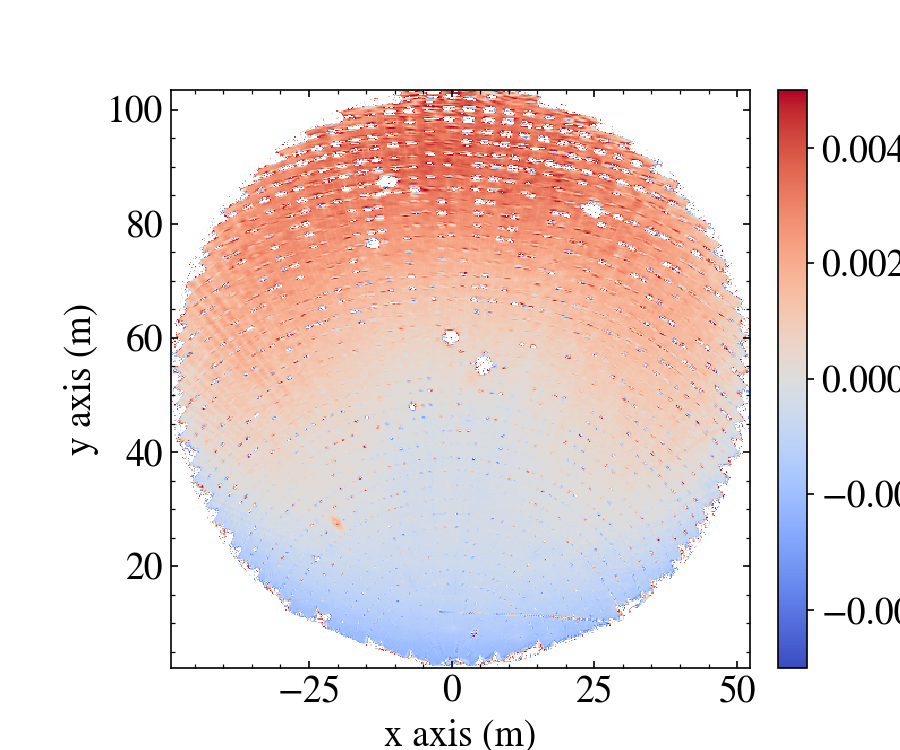

In [257]:
diff = sigma_clip(np.ma.masked_invalid(zsag - zrag), 3)
surfacePlot(xrag, yrag, diff.T)

In [258]:
%%time
window = (9,9)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    diff_rms = getRollingStat(diff, func=np.nanstd, window=window)
    diff_avg = getRollingStat(diff, func=np.nanmean, window=window)
    mask = ((diff - diff_avg)/diff_rms > 3.) | (diff_rms == 0) | (diff_rms >= 2e-3)

CPU times: user 581 ms, sys: 188 ms, total: 769 ms
Wall time: 767 ms


<IPython.core.display.Javascript object>


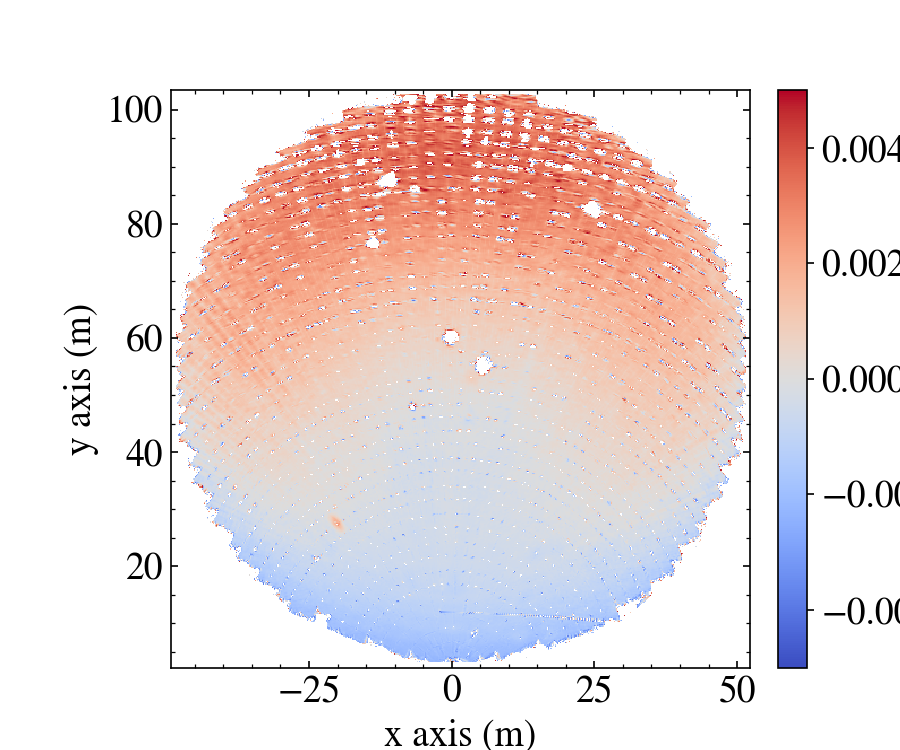

In [259]:
diff = np.ma.masked_where(mask, diff)
surfacePlot(xrag, yrag, diff.T)

<IPython.core.display.Javascript object>


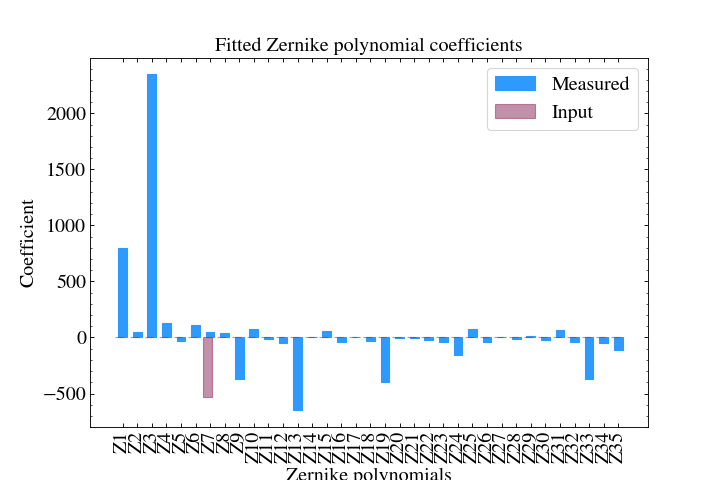

In [260]:
fl_fs = getZernikeCoeffs(diff.filled(0)[::-1].T, 36, norm='active-surface')
#window = (15,15)
#with warnings.catch_warnings():
#    warnings.simplefilter("ignore")
#    diff_rms_ = getRollingStat(diff, func=np.nanstd, window=window)
#fl_fs = zernikeWLS(xrag_, yrag_, diff[::-1,::-1], nZern, weights=np.power(diff_rms_[::-1,::-1], -2.))
barChartPlot(np.arange(1,36), fl_fs[1:36]*1e6, expected=zcoef[1:36])

<IPython.core.display.Javascript object>


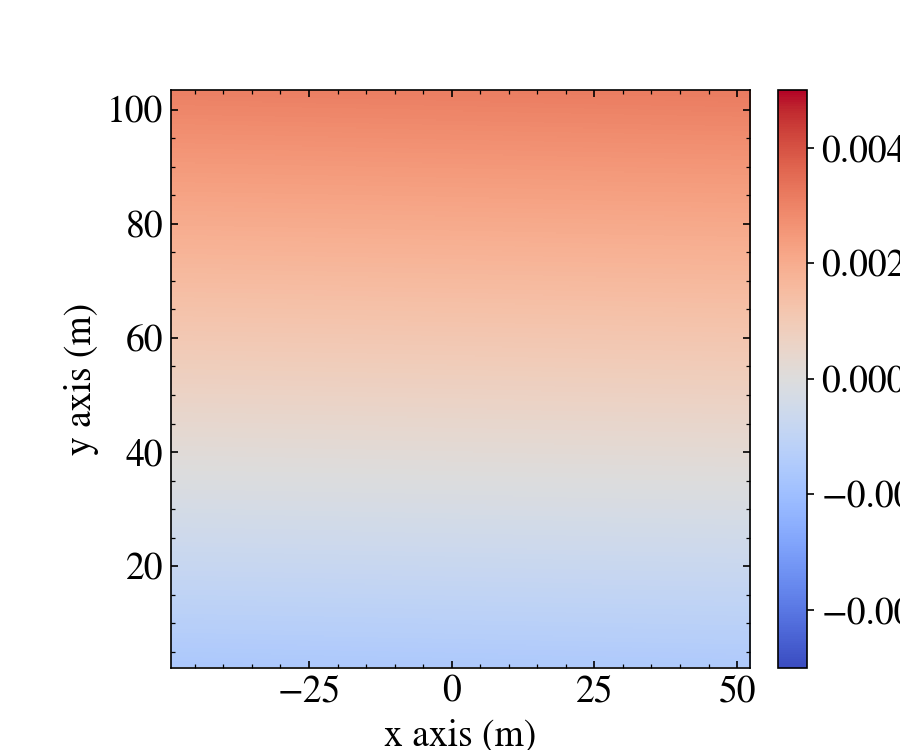

In [269]:
surfacePlot(xrag, yrag, zpoly_.T)

<IPython.core.display.Javascript object>


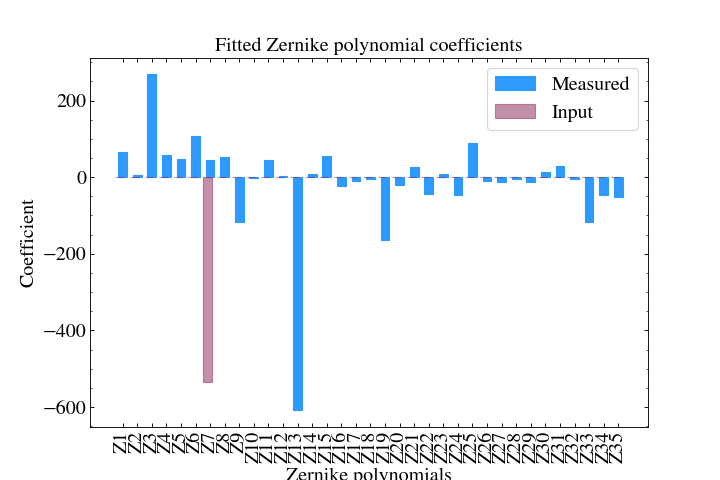

In [271]:
fl_fs_sub = np.copy(fl_fs)
fl_fs_sub[2] *= -1.
zpoly_ = zernikePoly(xrag, yrag, midPoint(xrag), midPoint(yrag), fl_fs_sub[0:4])
diff_ = diff - zpoly_
fl_fs_ = getZernikeCoeffs(diff_.filled(0)[::-1].T, 36, norm='active-surface')
#fl_fs_ = zernikeWLS(xrag_, yrag_, diff_[::1,::1], nZern, weights=None)
barChartPlot(np.arange(1,36), fl_fs_[1:36]*1e6, expected=zcoef[1:36])

<IPython.core.display.Javascript object>


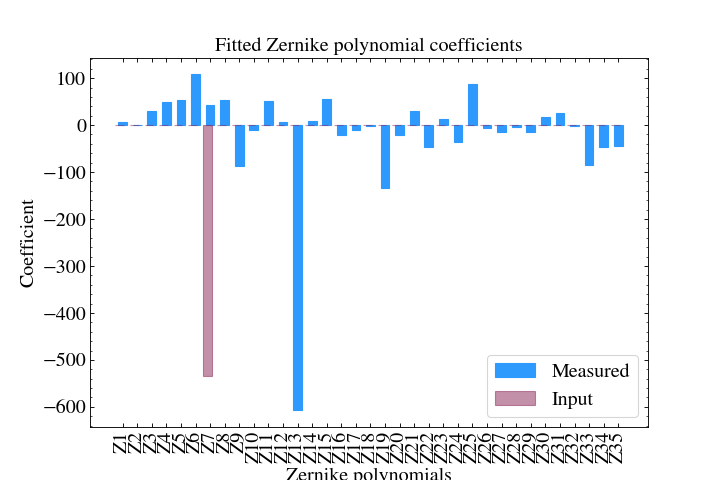

In [272]:
fl_fs_sub = np.copy(fl_fs_)
fl_fs_sub[2] *= -1.
zpoly_ = zernikePoly(xrag, yrag, midPoint(xrag), midPoint(yrag), fl_fs_sub[0:4])
diff__ = diff_ - zpoly_
fl_fs__ = getZernikeCoeffs(diff__.filled(0)[::-1].T, 36, norm='active-surface')
#fl_fs_ = zernikeWLS(xrag_, yrag_, diff_[::1,::1], nZern, weights=None)
barChartPlot(np.arange(1,36), fl_fs__[1:36]*1e6, expected=zcoef[1:36])

<IPython.core.display.Javascript object>


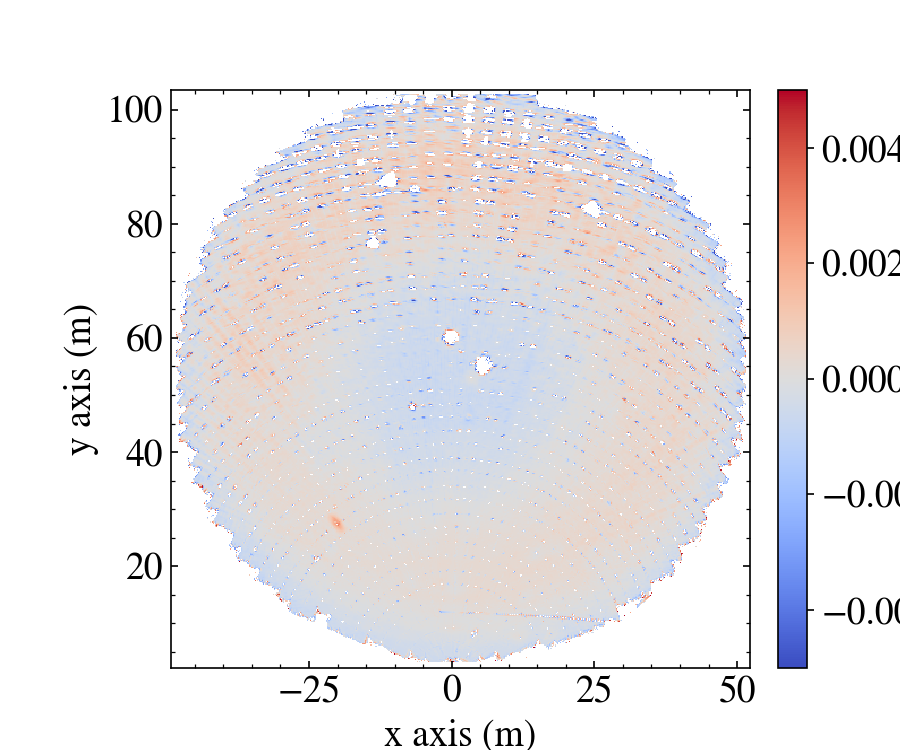

In [273]:
surfacePlot(xrag, yrag, diff__.T)

In [274]:
%%time
window = (9,9)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    diff_rms_ = getRollingStat(diff__, func=np.nanstd, window=window)
    diff_avg_ = getRollingStat(diff__, func=np.nanmean, window=window)
    mask_ = ((diff__ - diff_avg_)/diff_rms_ > 3.) | (diff_rms_ == 0) | (diff_rms_ >= 2e-3) | (abs(diff__) > 2e-3) 

CPU times: user 604 ms, sys: 231 ms, total: 835 ms
Wall time: 833 ms


<IPython.core.display.Javascript object>


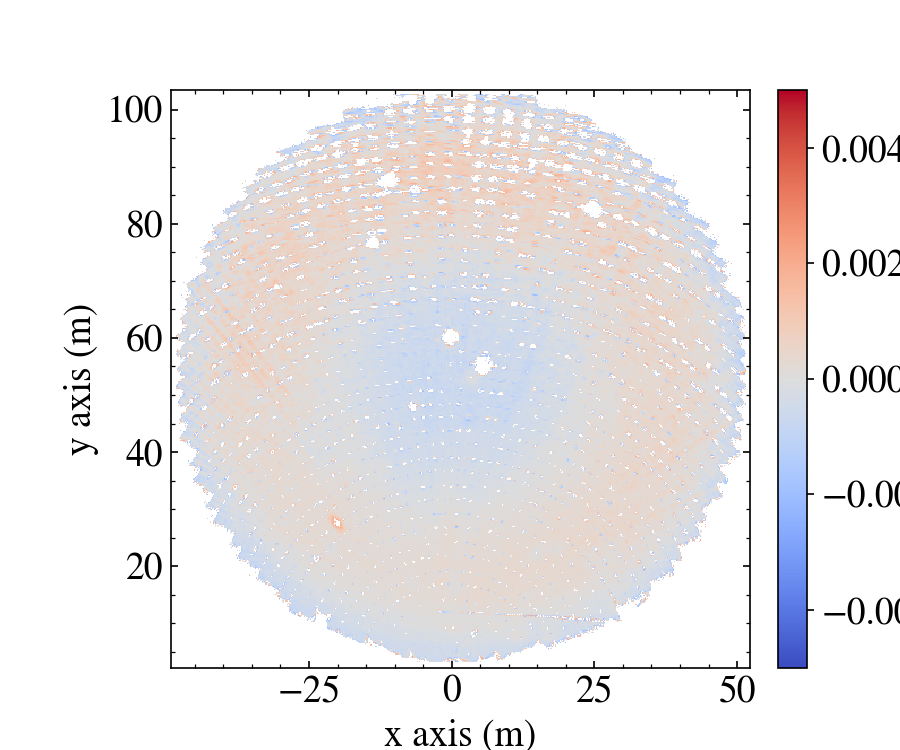

In [275]:
diff__ = np.ma.masked_where(mask_, diff__)
surfacePlot(xrag, yrag, diff__.T)

<IPython.core.display.Javascript object>


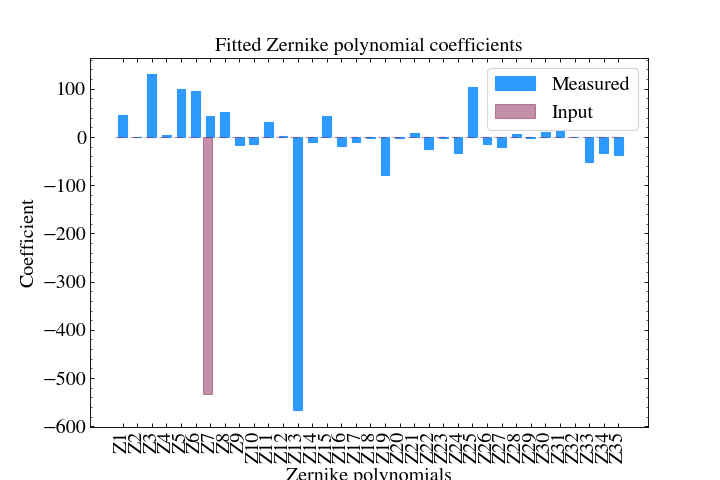

-567.0567599509376


In [277]:
fl_fs__ = getZernikeCoeffs(diff__.filled(0)[::-1].T, 36, norm='active-surface')
#fl_fs_ = zernikeWLS(xrag_, yrag_, diff_[::1,::1], nZern, weights=None)
barChartPlot(np.arange(1,36), fl_fs__[1:36]*1e6, expected=zcoef[1:36])
print(fl_fs__[13]*1e6)

In [151]:
fl_fs[4]*1e6, fl_fs_[4]*1e6

(656.1993036767393, -48.82039637360831)

In [152]:
fl_fs[7]*1e6, fl_fs_[7]*1e6

(9.60704802083161, 52.96201764528141)

In [191]:
fl_fs[13]*1e6, fl_fs_[13]*1e6

(-650.6369668810958, -608.7690786711642)

In [154]:
# Ci's from March - October.
# Using the mask from the parabola fitter.
fl_diff = np.array([ 0.00000000e+00, -3.69288510e-03, -1.49139347e-05, -3.52637492e-03,
       -1.20384279e-03,  3.42504620e-04, -6.94333784e-05,  7.45391278e-05,
       -2.82334099e-04,  1.16525931e-03, -5.20602079e-04,  7.60481614e-05,
        1.18311862e-03,  1.32807415e-03, -1.31880599e-05,  2.32681778e-04,
       -1.04560218e-04, -2.81682910e-05,  4.20666148e-04,  6.30305870e-04,
        5.67510711e-04, -5.28192266e-04,  4.95492629e-04, -3.32781178e-04,
        4.04544300e-04,  1.03737866e-03,  1.47115401e-04, -3.54065880e-04,
       -8.38001315e-05,  5.29861377e-07,  4.91299950e-04, -8.66901157e-05,
       -1.52489921e-07,  6.29674463e-04,  1.86082374e-04,  1.90359416e-04,
        3.80229172e-04])
fl_diff_ = np.array([ 0.00000000e+00, -3.71682792e-03, -2.58358180e-03, -3.53105556e-03,
       -1.20566590e-03,  3.32335485e-04,  2.32908596e-04, -1.74258160e-05,
        6.81334059e-04,  1.18443492e-03, -5.05738044e-04,  8.65598384e-05,
        1.17520943e-03,  1.32925720e-03, -1.63907828e-04,  7.86179735e-05,
       -5.58908977e-05,  1.21431588e-04,  1.29821922e-03,  6.49889436e-04,
        5.64216358e-04, -5.14556665e-04,  4.96710125e-04, -2.91337239e-04,
        4.24701050e-04,  1.05750007e-03, -2.12268496e-05, -2.99363465e-04,
       -1.60039236e-04,  5.87575395e-05,  4.14361538e-04,  2.16738385e-06,
        7.72271937e-04,  6.51354892e-04,  1.96974470e-04,  2.07264460e-04,
        3.67381666e-04])

In [155]:
fl_diff = np.array([ 0.00000000e+00, -4.95066941e-03,  1.78990849e-04, -5.99716659e-03,
       -2.89161217e-04, -9.11323119e-04, -1.31885912e-05, -1.39847453e-04,
       -1.55114349e-04,  7.97151571e-04, -4.90269608e-04,  4.01070621e-04,
        5.87779993e-04,  7.49339935e-04, -2.38696729e-04,  1.78838369e-04,
        7.67140344e-05,  6.14181659e-05,  5.80052364e-04,  6.05003080e-04,
        3.27972954e-05, -7.81413338e-05,  5.99882342e-05, -1.03757820e-04,
        3.40930544e-04,  6.27484577e-04,  1.03829085e-04,  1.88756803e-06,
       -9.53187559e-05,  1.80298431e-05,  1.80692083e-04, -2.88046599e-04,
        2.60141989e-05,  6.34869244e-04,  9.62421357e-05,  4.56551029e-05,
        1.24674452e-04])
fl_diff_ = np.array([ 0.00000000e+00, -4.79423428e-03, -5.32398155e-03, -6.00016313e-03,
       -3.07888519e-04, -9.57284246e-04, -3.74535852e-05, -1.49184994e-04,
        6.28182959e-04,  8.18853488e-04, -4.76942360e-04,  4.32472011e-04,
        5.56862712e-04,  6.93640505e-04, -4.11982835e-04,  2.75246465e-05,
        1.16604493e-04,  1.98153847e-04,  1.53545303e-03,  6.52331555e-04,
        7.27764908e-05, -6.02058241e-05,  5.93541352e-05, -9.80896108e-05,
        3.00272224e-04,  5.79159840e-04, -1.37778391e-04, -6.20661561e-05,
       -2.18875209e-04,  2.69735536e-05,  2.03614890e-04, -1.35585651e-04,
        1.04023629e-03,  6.83742294e-04,  1.25574412e-04,  2.96015210e-05,
        1.04995170e-04])

In [156]:
(fl_fs[iz] - fl_diff[iz])*1e6, (fl_fs_[iz] - fl_diff_[iz])*1e6

(-1529.3145981917296, -1445.3541998599935)